# Semi-structured NN 
## ISIC archive 2020 melanoma dataset
https://challenge2020.isic-archive.com/

In [113]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from keras.layers import Dropout
from tensorflow import keras
import seaborn as sns
import keras
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from numpy.random import seed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img

%load_ext autoreload
%autoreload 2
from functions.scoreCI import score_ci, score_stat_ci
from functions.vimlts import VimltsLinear
from functions.sample_bernoulli_nll import sample_bernoulli_nll

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

- Image dataset resized to 128,128,3
- Tabular data with standardized age mean 0, variance 1
- 80% training set, 20% of training set used for validation set, 20% test set

In [27]:
## add resize images and add path to patient
dat = pd.read_csv('../MA/patientData.csv')
train_dir = "../MA/trainRes/"
dat['path'] = train_dir + dat.image_name + ".jpg"

In [28]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)


train_idx = idx[:int(len(dat)*0.8)] 
test_idx = idx[int(len(dat)*0.8):] 
valid_idx = train_idx[:int(len(train_idx)*0.2)] 
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [29]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
print(X_train.shape, X_valid.shape, X_test.shape)

(21200, 9) (5300, 9) (6626, 9)


In [30]:
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)


In [31]:
X_trainAge = dat.iloc[train_idx]
X_trainAge = X_train.loc[:, X_train.columns.intersection(['age_approx'])]
X_validAge= dat.iloc[valid_idx]
X_validAge = X_valid.loc[:, X_train.columns.intersection(['age_approx'])]
X_testAge= dat.iloc[test_idx]
X_testAge = X_test.loc[:, X_train.columns.intersection(['age_approx'])]

## Standardize tabular data

In [32]:
def standard(data):
    mean = np.mean(data)
    std = np.std(data)
    standard = (data - mean) / std
    return standard

In [33]:
standAgeTr = standard(X_trainAge)
standAgeVal = standard(X_validAge)
standAgeTe= standard(X_testAge)

## Image data preprocessing

In [34]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# img_to_array 
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)
train_labels = y_train

validation_imgs = np.array(validation_imgs)
val_labels = y_valid

test_imgs = np.array(test_imgs)
test_labels = y_test


print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape,
      '\Test dataset shape:', test_imgs.shape)

Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


In [35]:
#scale pixel between 0 und 1

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")

train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

#plt.imshow(train_imgs_scaled[0])

### Functions 

In [88]:
def softplus_inv(y):
    return np.log(np.exp(y) - 1)

def neg_log_likelihood(y_obs, y_pred):
    likelihoodElements= -(y_obs*np.log(y_pred) + (1 - y_obs)*np.log(1 - y_pred))
    nll = np.mean(likelihoodElements)
    return print(nll.values[0])

### Parameters

In [37]:
opt = RMSprop()
batch_size=256
num_samples = 1000
M=50 
prior_dist=tfd.Normal(loc=0.,scale=1.)

## CNN without TM-VI

In [38]:
initializer = keras.initializers.HeNormal(seed = 3004)
    
inImg = keras.Input(shape = (128,128,3), name = "inImg")

x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(inImg)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
    
out = layers.Dense(1, activation = "sigmoid")(x) 
    
imageMod = Model(inImg, out)

#imageMod.summary()

In [39]:
imageMod.compile(loss="binary_crossentropy", optimizer=opt,run_eagerly=False)

In [40]:
results = imageMod.fit(x=train_imgs_scaled,
                       y = train_labels,
                       validation_data = (validation_imgs_scaled, val_labels),
                       batch_size=batch_size,
                       epochs = 50,
                       verbose= False)   

In [44]:
### save model weights
#imageMod.save_weights("models/CNN", save_format ="tf")

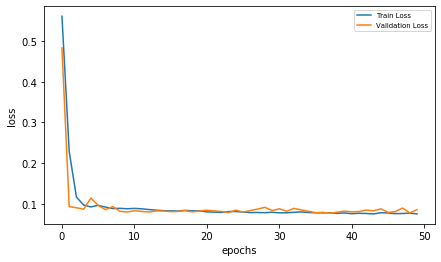

In [41]:
plt.figure(figsize=(7,4))
plt.plot(imageMod.history.history['loss'],label="Train Loss")
plt.plot(imageMod.history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')

### Performance NLL & AUC

In [82]:
y_pred = imageMod.predict(test_imgs_scaled).ravel()
predictions=y_pred.reshape(6626,1)

In [90]:
## NLL
neg_log_likelihood(test_labels, predictions)

0.08480645633335343


In [91]:
###AUC
score, ci_lower, ci_upper, scores =score_ci(test_labels, y_pred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)
log_loss = "{:.3f}".format(log_lossCNN)
auc= "{:.2f}".format(auc_kerasCNN)

AUC=0.76, 95% CI: 0.71-0.80


## CNN + Tabular BF-VI

In [93]:
## Complex shift image

initializer = keras.initializers.HeNormal(seed = 2802)
    
inImg = keras.Input(shape = (128,128,3), name = "inImg")

x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(inImg)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
                        
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation = 'tanh', kernel_initializer = initializer)(x)
x = layers.BatchNormalization(center=True, scale=True)(x)
x = layers.Dropout(0.3)(x)
    
eta = layers.Dense(1, activation = "linear")(x) 
    
out = K.expand_dims(eta, axis=0)
outr = tf.keras.backend.repeat_elements(out,1000,axis=0)


nn_img = Model(inImg, outr)

#nn_img.summary()

In [95]:
### Linear shift tabular MF-TMVI-Methode


theta_start = -1
theta_stop = 1
delta_theta = softplus_inv((theta_stop-theta_start)/(M))
vimlts_initializersConv2D=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] 
                               + [initializers.Constant(delta_theta) for _ in range(M)])



inCov = keras.Input(shape = standAgeTr.shape[1:], name = 'inCov')
outCov = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,
                      num_samples=num_samples,
                      size = standAgeTr.shape[0],
                      **vimlts_initializersConv2D,
                      prior_dist=prior_dist)(inCov)

nn_tab = keras.Model(inputs = inCov, outputs = outCov)
nn_tab.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpeno_7g34.py, line 51)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpeno_7g34.py, line 51)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inCov (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
vimlts_linear (VimltsLinear) (1000, None, 1)           55        
Total params: 55
Trainable params: 55
Non-trainab

In [96]:
def combinedModel(X, X_meta):
    added = tf.keras.layers.Add()([X_meta.output, X.output]) 
    out = tf.keras.layers.Dense(train_labels.shape[1], activation = 'sigmoid')(added)
    model = keras.Model(inputs = [X_meta.input, X.input], outputs = out, name='model_2')
    return model

In [97]:
model = combinedModel(nn_tab, nn_img)
model.compile(loss=sample_bernoulli_nll, optimizer=opt,run_eagerly=False,metrics=[sample_bernoulli_nll])

In [ ]:
results = model.fit(x=[train_imgs_scaled, standAgeTr],
                     y = train_labels,
                     validation_data = ([validation_imgs_scaled, standAgeVal], val_labels),
                     batch_size=batch_size,
                     epochs = 10,
                     verbose= False) 
### save model weights
#model1.save_weights("models/CNN+MFBFTabular", save_format ="tf")

In [98]:
### recreate Model
model.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
model.fit(x =[train_imgs_scaled,standAgeTr],y = train_labels, verbose=True)
### load the state of the old model
model.load_weights("../thesis/models/CNN+MFBFTabular")

663/663 [==============================] - 67s 68ms/step - loss: 0.3677 - sample_bernoulli_nll: 0.3535


### Posterior parameter $\beta_\text{Age}$

Text(0, 0.5, '$p(\\beta_1|D)$')

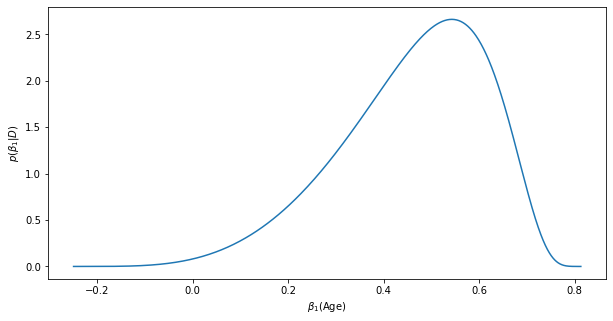

In [116]:
plt.figure(figsize=(10,5))
### get slope parameter from tabular model 
layer = nn_tab.layers[1]
qw, w = layer.get_w_dist()
plt.plot(w, qw, linewidth=1.5)
plt.xlabel("$\\beta_1$(Age)")
plt.ylabel("$p(\\beta_1|D)$")
plt.xlabel("$\\beta_1$(Age)")
plt.ylabel("$p(\\beta_1|D)$")

### Performance NLL & AUC

In [103]:
### performance
xtest = [test_imgs_scaled, standAgeTe]
y_pred = model.predict(xtest,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

In [105]:
logloss = neg_log_likelihood(test_labels,predictions)

0.07633597942399716


In [108]:
###AUC
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)
log_loss = "{:.3f}".format(log_lossCNN)
auc= "{:.2f}".format(auc_kerasCNN)


AUC=0.82, 95% CI: 0.79-0.85


## Compare with MCMC

In [109]:
mcmc = pd.read_csv('../thesis/mcmcSampleTabular.csv')
sampleSlope = mcmc["slope"]

Text(0, 0.5, 'density')

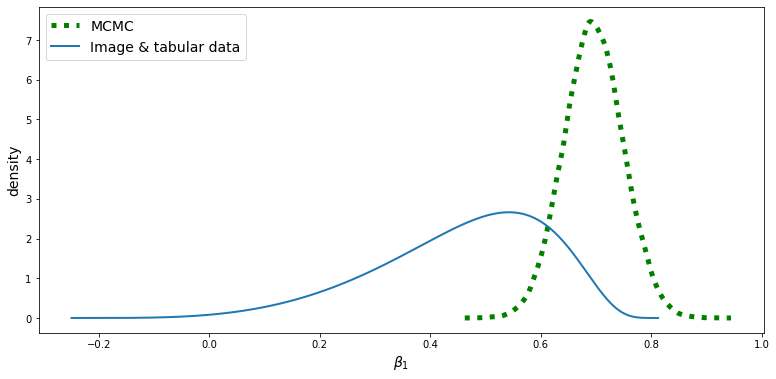

In [115]:
#### plot variational Distribution
plt.figure(figsize=(13,6))
sns.kdeplot(sampleSlope, color='g',zorder=2, label=r'MCMC',linewidth=5., linestyle=(0, (1, 1.5)))
plt.plot(w, qw, label ="Image & tabular data",linewidth=2.0)
plt.legend(fontsize=14)
plt.xlabel("$\\beta_1$",fontsize=14)
plt.ylabel("density",fontsize=14)